In [1]:
import sys
#sys.path.append('/home/emastr/phd/')

from boundary_solvers.gauss_grid_2d import *
import numpy as np
import matplotlib.pyplot as plt
from util.plot_tools import *
from boundary_solvers.blobs import *
from scipy.sparse.linalg import gmres, LinearOperator
from util.unet import *

### Beating GMRES on a well-conditioned system - Is it possible?
In this short project we examine the possibility to accelerate the mapping from boundary data to boundary conditions using deep learning. Given boundary data $u \colon \partial\Omega \to \mathbb{R}$ of a region $\Omega$ of Euclidean space $\mathbb{R}^d$ whose boundary is parameterised by some $\gamma \colon [0,2\pi] \to \mathbb{R}^d$, the density $\rho$ is obtained as

\begin{equation}
 \mathcal{A}_\gamma \rho = u
\end{equation}

where the operator $\mathcal{A}_\gamma$ is parameterised by $\gamma$. Without getting to caught up in the details, GMRES takes the iterative form

\begin{equation}
     \rho_{n} = step(\mathcal{A}_\gamma, \rho_{m<n}),\qquad \rho_0 = u.
\end{equation}

Due to well-posedness of $\mathcal{A}_\gamma$, the number of iterations required is low for smooth systems. In such cases, the number of iterations required for machine precision is on the scale of 10-20. However, when introducing corners into the geometry, it becomes harder to obtain good convergence. Furthermore, preconditioners can be expensive so if the corner geometry is unpredictable (i.e. the angle of the corner), this solution needs improvement. 


#### Learning $\mathcal{A}_\gamma^{-1}$

We define a data point as an array containing the Fourier coefficients for the boundary and boundary condition. This is contained in the `ProblemData` class along with some help functions. The function `ProblemData.random_problemdata()` can be used to sample a data point with a fixed number of coefficients. Given some number $K$, the Fourier coefficients $c_k\in \mathbb{C}$ are generated using samples $c$ from a $\mathcal{N}(0,\sigma)$ distributed variable:

\begin{equation}
    c_k = 
    \begin{cases}
    0, & \text{if} \quad k=-1,0\\
    1, & \text{if} \quad k=1\\
    c e^{-d|k|}, &\text{otherwise}
    \end{cases}
\end{equation}

Here, $d,\sigma$ are hyper parameters, called `decay` and `amplitude` in the code. The data can be converted to a dirichlet problem using `ProblemData.to_problem()`. However, for the resulting problem to be well-posed, two conditions must be satisfied: The boundary should not intersect itself, and the dirichlet velocity should integrate to zero along the boundary. These two conditions can be enforced by passing the variables `allow_intersections` and `allow_net_flow` to the `random_problemdata()` function. These are implemented in different ways.

* The self intersections are eliminated by applying rejection sampling: 
    1. Sample $c_k$, check for intersections.
    2. If no intersections are found, $c_k$ is accepted. 
    3. If an intersection is found, repeat from step 1.
    
    
* The net flow is eliminated by introducing a correction $\delta_k$ to the Fourier coefficients,
  that satisfy
     \begin{equation}
           \min_{\delta_k} \sum_{k=-K}^K (1+|k|)^\alpha||\delta_k||^2, \quad \text{subject to zero net flow.}
     \end{equation}
   Here, $\alpha$ is a parameter that if high, dampens high frequency corrections to the field.
   


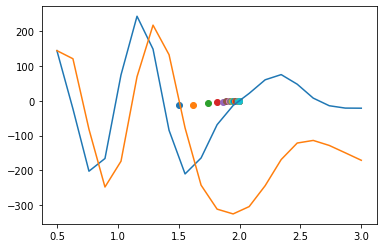

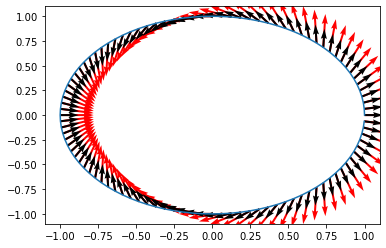

In [55]:
import torch
import torch.autograd as agrad
import numpy as np
import matplotlib.pyplot as plt
from operators.stokes_operator import StokesOperator

N = 100
dt = np.pi * 2 / N
t  = torch.arange(0,N) * dt
z = torch.exp(1j * t)
dz = 1j * z;
ddz = 1j**2 * z;
w = torch.ones(N,) * dt

#print(w.to(dtype=z.dtype))
a = torch.Tensor([1.5])
a.requires_grad_(True)

v = torch.exp(1j * a * t)[None, None, :]
#v.requires_grad_(True)
v0 = torch.exp(2j * t)[None, None, :]

A = StokesOperator(z, dz, ddz, w)

# Network
def net(a):
    v = torch.exp(1j * a * t)[None, None, :]
    v.requires_grad_(True)
    for i in range(5):
        mse = torch.norm(A(v) - v0)**2
        v = v - 0.1 * agrad.grad(mse, v, retain_graph=True, create_graph=True)[0]
    return v

# Training
grads = []
alist = torch.linspace(0.5,3,20)
for ai in alist:
    ai.requires_grad_(True)
    loss = torch.norm(net(ai) - v0) ** 2
    
    ai.retain_grad()
    loss.backward()
    
    grads.append(ai.grad.numpy())

for i in range(30):
    loss = torch.norm(net(a) - v0) ** 2 * dt
    a.retain_grad()
    loss.backward()    
    plt.scatter(a.detach(), a.grad.detach())
    a = a - 0.01*a.grad
    a.grad = None
    
    
plt.plot(alist, grads)
plt.plot(alist, np.cumsum(np.array(grads)))
plt.figure()
v = net(a).detach()
 
x, y = torch.real(z), torch.imag(z)
ux, uy = torch.real(v.squeeze()), torch.imag(v.squeeze())
ux0, uy0 = torch.real(v0.squeeze()), torch.imag(v0.squeeze())

plt.plot(x, y)
plt.quiver(x, y, ux0, uy0, color = 'red', scale=10)
plt.quiver(x, y, ux, uy)

In [ ]:
np.random.seed(0)
# Create simple counting callback
class Callback:
    def __init__(self):
        self.counter = 0
        
    def __call__(self, args):
        self.counter += 1
        
    def reset(self):
        self.counter = 0
callback = Callback()

# Generate some data
data = []
sols = []
corrs = []
n = 4
plt.figure(figsize=(15,15))
for i in range(n*n):
    callback.reset()
    
    # Generate data
    data.append(ProblemData.random_problemdata(K=20, 
                                               bound_amplitude=0.1,
                                               bound_decay=0.5, 
                                               cond_amplitude=0.5,
                                               cond_decay=0.4,
                                               allow_intersections=False, 
                                               allow_net_flow=False,
                                               decay_type="exp",
                                               refine=4,
                                               tol=1e-13))
                                               #allow_intersections=(i >= n*n//2), tol=1e-10))
    # Solve
    problem = data[-1].to_problem(n=4)
    problem.solve(callback=callback, tol=1e-13)
    sols.append(problem)
    
    # Plot data
    plt.subplot(n,n,i+1)
    problem.plot(ax=plt.gca())
    plt.axis("equal")
    plt.legend()
    remove_axes(plt.gca())
    
    pts = problem.geometry.self_intersections(tol = 1e-13)
    plt.scatter([np.real(z) for z in pts], [np.imag(z) for z in pts], 
                s=100, color='black', marker='x',zorder=3, linewidth=5)
    print(f"problem {i}, solve finished in {callback.counter} iterations")

We can look at these mappings as a function of the boundary parameter to get an understanding of the mapping from boundary and dirichlet conditions to the density.

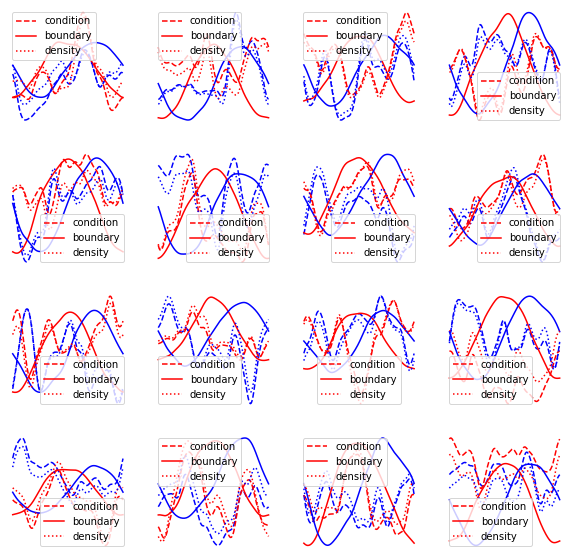

In [11]:
plt.figure(figsize=(10,10))
for i,sol in enumerate(sols):
    plt.subplot(n,n,i+1)
    coefs = sol.fourier_density(K=20)
    t, _ = sol.geometry.grid.get_grid_and_weights()
    condition = sol.condition(t)
    boundary = sol.geometry.eval_param(derivative=0)
    
    plt.plot(t,  np.real(condition),'b--')
    plt.plot(t, -np.imag(condition),'r--', label='condition')
    
    plt.plot(t, -np.real(boundary),'r', label='boundary')
    plt.plot(t, -np.imag(boundary),'b')
    
    plt.plot(t, np.real(sol.density),'r:', label='density')
    plt.plot(t, np.imag(sol.density),'b:')
    
    remove_axes(plt.gca())
    plt.legend()
    

Here's a closer look at the corresponding solutions to the stokes problems.

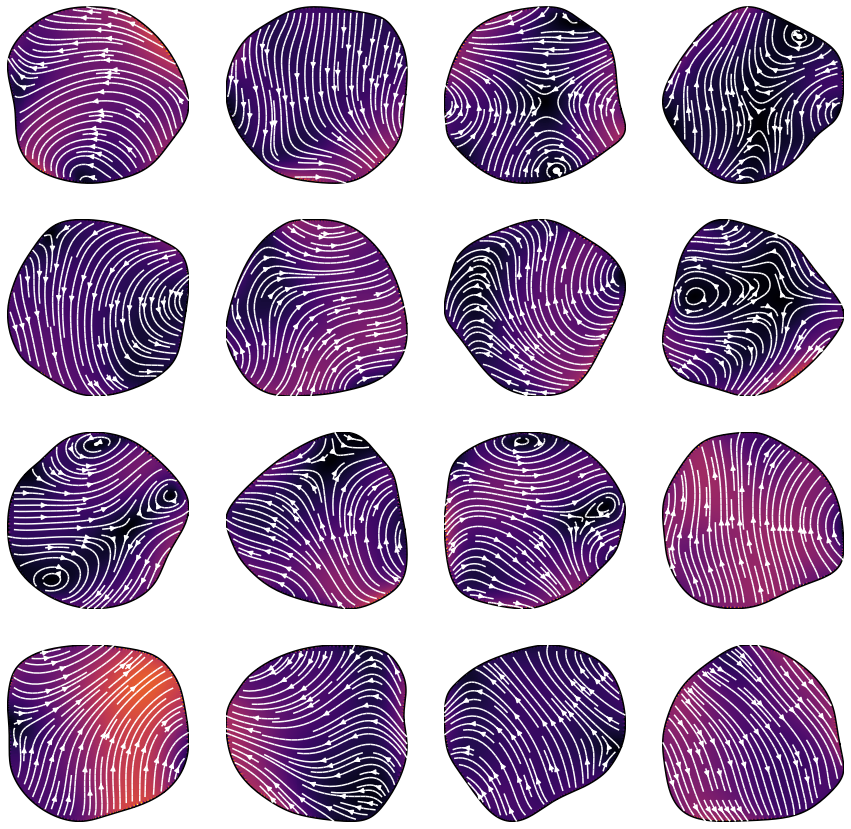

In [4]:
plt.figure(figsize=(15,15))
for i, sol in enumerate(sols):
    plt.subplot(n,n,i+1)
    def speed(z):
        vel = sol.evaluate(z)
        return np.abs(vel)
    sol.geometry.plot(ax=plt.gca(), color='black')
    sol.geometry.plot_field(ax=plt.gca(), func=speed, apply_mask=True, vmin=0, vmax=4, cmap="inferno")
    sol.geometry.plot_stream(ax=plt.gca(), func=sol.evaluate, apply_mask=True, color='white')
    remove_axes(plt.gca())

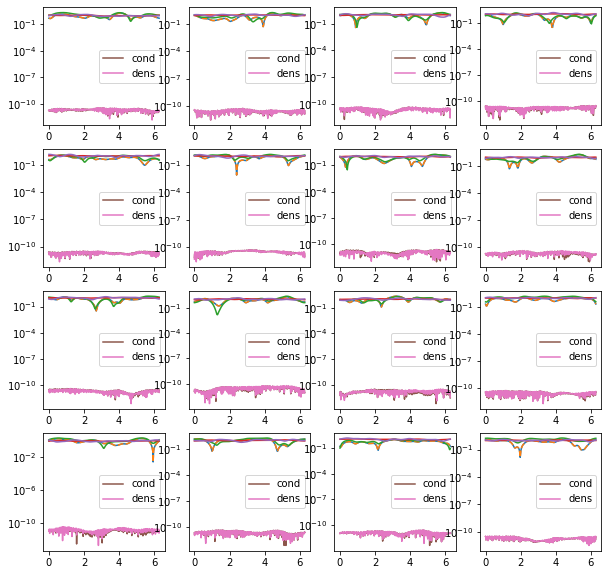

In [5]:
plt.figure(figsize=(10,10))
for i,sol in enumerate(sols):
    t, _ = sol.geometry.grid.get_grid_and_weights()
    
    dens = sol.density
    dens_2 = sol.inv_fourier_tfm(sol.fourier_tfm(lambda t: dens, 60), 60)
    dens_2 = dens_2(t)
    
    cond = sol.inv_fourier_tfm(sol.fourier_tfm(sol.condition, 60), 60)
    cond = cond(t)
    
    plt.subplot(n,n,i+1)
    #plt.plot(t, np.imag(dens))
    #plt.plot(t, np.imag(dens_2))
    #remove_axes(plt.gca())
    plt.plot(t, np.abs(dens))
    plt.plot(t, np.abs(dens_2), '--')
    
    plt.plot(t, np.abs(sol.condition(t)))
    plt.plot(t, np.abs(sol.geometry.param[0](t)))
    plt.plot(t, np.abs(sol.geometry.param[1](t)))
    
    plt.plot(t, np.abs(cond - sol.condition(t)), label='cond')
    plt.plot(t, np.abs(dens - dens_2), label='dens')
    
    plt.yscale("log")
    
    plt.legend()
    

## Generate and save the data into a big file.

In [6]:
import torch

# Create simple counting callback
class Callback:
    def __init__(self, printer):
        self.counter = 0
        self.printer = printer
        
    def __call__(self, args=None):
        self.counter += 1
        self.printer(self)
        
    def reset(self):
        self.counter = 0

N = 200

# Number of modes for in data 
K_in = 20
Kbig_in = 2*K_in + 1

# Number of modes for out data
K_out = 60
Kbig_out = 2*K_out + 1

# Allocate spac
in_data = torch.zeros(N, 4, Kbig_in) # Input data (real, imag) x (bound, condition)
out_data = torch.zeros(N, 2, Kbig_out) # Output (real, imag) x density

for i in range(N):
    callback = Callback(printer=lambda cb: 
                        print(f"Generating datapoint {i+1}/{N}. No resamples = {cb.counter}", end="\n"))
    
    data = ProblemData.random_problemdata(K=K_in, 
                                          bound_amplitude=0.1,
                                          bound_decay=0.5, 
                                          cond_amplitude=0.5,
                                          cond_decay=0.4,
                                          allow_intersections=False, 
                                          allow_net_flow=False,
                                          decay_type="exp",
                                          refine=4,
                                          callback=callback,
                                          tol=1e-13)
                                          #allow_intersections=(i >= n*n//2), tol=1e-10))
    print(f"Generating datapoint {i+1}/{N}. Solving system for density", end="\n")
    # Solve
    data.set_density(n=4, tol=1e-13, K_density=K_out, maxiter=20)
    
    print(f"Generating datapoint {i+1}/{N}. Setting data.", end="\n")
    # Set in data
    in_data[i, 0, :] = torch.from_numpy(np.real(data.bound_coef))
    in_data[i, 1, :] = torch.from_numpy(np.imag(data.bound_coef))
    in_data[i, 2, :] = torch.from_numpy(np.real(data.u_coef))
    in_data[i, 3, :] = torch.from_numpy(np.imag(data.u_coef))
    
    # set out data
    out_data[i, 0, :] = torch.from_numpy(np.real(data.density_coef))
    out_data[i, 1, :] = torch.from_numpy(np.imag(data.density_coef))
    

Generating datapoint 1/200. No resamples = 1
Generating datapoint 1/200. Solving system for density
Generating datapoint 1/200. Setting data.
Generating datapoint 2/200. No resamples = 1
Generating datapoint 2/200. Solving system for density
Generating datapoint 2/200. Setting data.
Generating datapoint 3/200. No resamples = 1
Generating datapoint 3/200. Solving system for density
Generating datapoint 3/200. Setting data.
Generating datapoint 4/200. No resamples = 1
Generating datapoint 4/200. Solving system for density
Generating datapoint 4/200. Setting data.
Generating datapoint 5/200. No resamples = 1
Generating datapoint 5/200. Solving system for density
Generating datapoint 5/200. Setting data.
Generating datapoint 6/200. No resamples = 1
Generating datapoint 6/200. Solving system for density
Generating datapoint 6/200. Setting data.
Generating datapoint 7/200. No resamples = 1
Generating datapoint 7/200. Solving system for density
Generating datapoint 7/200. Setting data.
Genera

Generating datapoint 57/200. Setting data.
Generating datapoint 58/200. No resamples = 1
Generating datapoint 58/200. Solving system for density
Generating datapoint 58/200. Setting data.
Generating datapoint 59/200. No resamples = 1
Generating datapoint 59/200. Solving system for density
Generating datapoint 59/200. Setting data.
Generating datapoint 60/200. No resamples = 1
Generating datapoint 60/200. Solving system for density
Generating datapoint 60/200. Setting data.
Generating datapoint 61/200. No resamples = 1
Generating datapoint 61/200. Solving system for density
Generating datapoint 61/200. Setting data.
Generating datapoint 62/200. No resamples = 1
Generating datapoint 62/200. Solving system for density
Generating datapoint 62/200. Setting data.
Generating datapoint 63/200. No resamples = 1
Generating datapoint 63/200. Solving system for density
Generating datapoint 63/200. Setting data.
Generating datapoint 64/200. No resamples = 1
Generating datapoint 64/200. Solving syst

Generating datapoint 114/200. Solving system for density
Generating datapoint 114/200. Setting data.
Generating datapoint 115/200. No resamples = 1
Generating datapoint 115/200. Solving system for density
Generating datapoint 115/200. Setting data.
Generating datapoint 116/200. No resamples = 1
Generating datapoint 116/200. Solving system for density
Generating datapoint 116/200. Setting data.
Generating datapoint 117/200. No resamples = 1
Generating datapoint 117/200. Solving system for density
Generating datapoint 117/200. Setting data.
Generating datapoint 118/200. No resamples = 1
Generating datapoint 118/200. Solving system for density
Generating datapoint 118/200. Setting data.
Generating datapoint 119/200. No resamples = 1
Generating datapoint 119/200. Solving system for density
Generating datapoint 119/200. Setting data.
Generating datapoint 120/200. No resamples = 1
Generating datapoint 120/200. Solving system for density
Generating datapoint 120/200. Setting data.
Generating 

Generating datapoint 169/200. Setting data.
Generating datapoint 170/200. No resamples = 1
Generating datapoint 170/200. Solving system for density
Generating datapoint 170/200. Setting data.
Generating datapoint 171/200. No resamples = 1
Generating datapoint 171/200. Solving system for density
Generating datapoint 171/200. Setting data.
Generating datapoint 172/200. No resamples = 1
Generating datapoint 172/200. Solving system for density
Generating datapoint 172/200. Setting data.
Generating datapoint 173/200. No resamples = 1
Generating datapoint 173/200. Solving system for density
Generating datapoint 173/200. Setting data.
Generating datapoint 174/200. No resamples = 1
Generating datapoint 174/200. Solving system for density
Generating datapoint 174/200. Setting data.
Generating datapoint 175/200. No resamples = 1
Generating datapoint 175/200. Solving system for density
Generating datapoint 175/200. Setting data.
Generating datapoint 176/200. No resamples = 1
Generating datapoint 

In [7]:
# Save data to file
data = {"X": in_data, "Y": out_data}
torch.save(data, "data/problem_data.torch")

### Fully Connected Neural network in the Fourier Domain
We start with a simple approach, a fully connected network with one hidden layer. The objective is to minimise the mean square error of the fourier coefficients. How many nodes is enough in the hidden layer? 

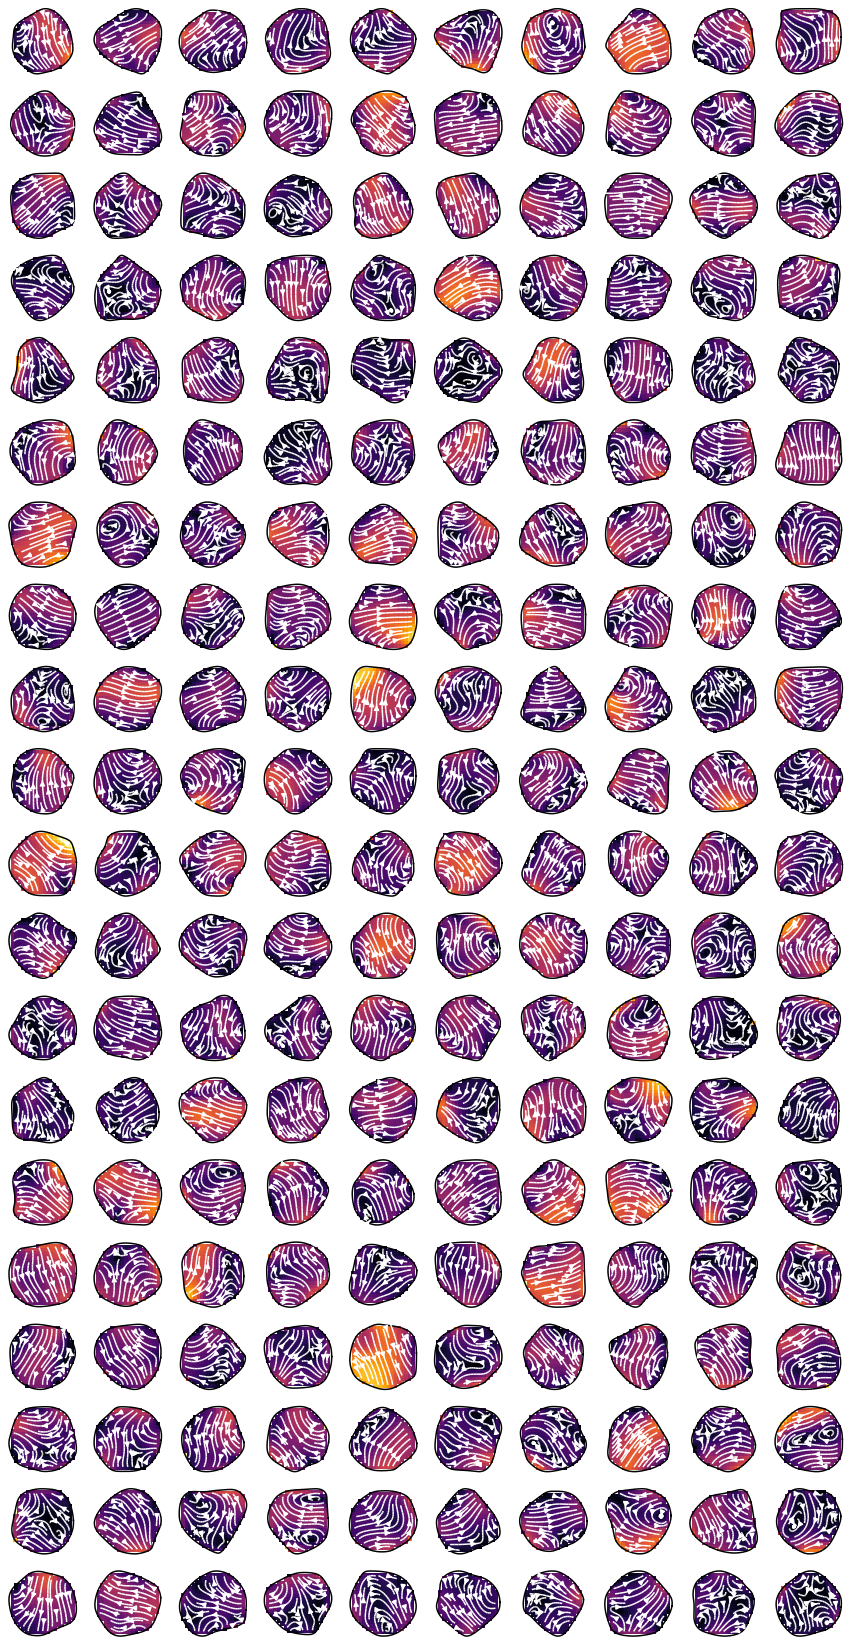

In [2]:
data = torch.load("data/problem_data.torch")
x = data["X"] # Remove later
y = data["Y"]

N = x.shape[0]
K_in = x.shape[2] // 2
K_out = y.shape[2] // 2

# 2*5*5*1
#grid = GaussLegGrid(segments=np.linspace(0,np.pi*2,8), corners=None)
plt.figure(figsize=(15,30))
for i in range(N):
    plt.subplot(20,10,i+1)
    data = ProblemData(bound_coef = (x[i, 0, :] + 1j * x[i, 1, :]).numpy(), 
                       u_coef = (x[i, 2, :] + 1j * x[i, 3, :]).numpy(), 
                       density_coef=(y[i, 0, :] + 1j * y[i, 1, :]).numpy())
    problem = data.to_problem(n=4)
    field = lambda z: np.abs(problem.evaluate(z))
    
    problem.geometry.plot(ax = plt.gca(), color="black")
    problem.geometry.plot_field(ax=plt.gca(), func=field, npts=20, apply_mask=True, cmap="inferno", vmin=0, vmax=3)
    problem.geometry.plot_stream(ax=plt.gca(), func=problem.evaluate, npts=20, apply_mask=True, color="white", density=0.5)
    plt.axis("equal")
    remove_axes(plt.gca())
   

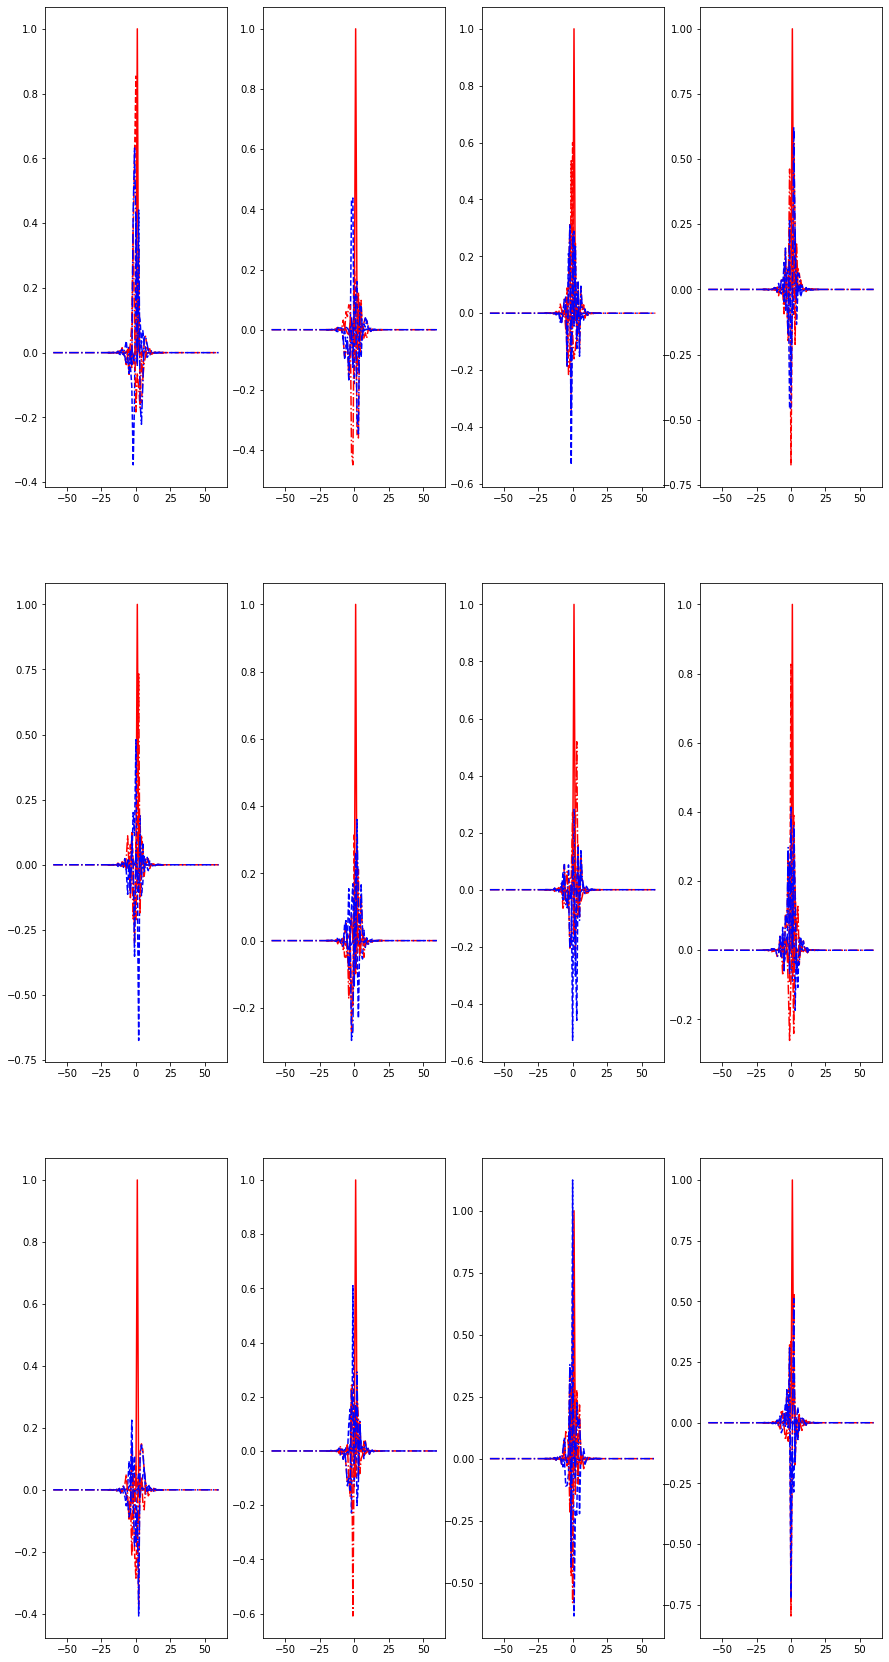

In [3]:
plt.figure(figsize=(15,30))
k_in = np.linspace(-K_in, K_in, 2*K_in+1)
k_out = np.linspace(-K_out, K_out, 2*K_out+1)
for i in range(12):
    plt.subplot(3,4, i+1)
    i = 74 + i
    plt.plot(k_in, x[i, 0, :], 'r-')
    plt.plot(k_in, x[i, 1, :], 'b-')
    plt.plot(k_in, x[i, 2, :], 'r--')
    plt.plot(k_in, x[i, 3, :], 'b--') 
    plt.plot(k_out, y[i, 0, :], 'r-.')
    plt.plot(k_out, y[i, 1, :], 'b-.')
    

In [4]:
import torch.nn as nn
import torch.nn.functional as F

device = "cuda"

d_in = x.shape[1] * x.shape[2]
d_out = y.shape[1] * y.shape[2]
d_hide = 10*d_in

xflat = x.view(N, d_in).to(device)
yflat = y.view(N, d_out).to(device)

class Net(torch.nn.Module):
    def __init__(self, n_hidden):
        super(Net, self).__init__()
        self.activation = nn.Sigmoid() # F.relu
        self.input_layer = nn.Linear(in_features=d_in, out_features=d_hide, bias=True)
        
        # hidden layers
        self.hidden_layers = nn.ModuleList([nn.Linear(in_features=d_hide, out_features=d_hide, bias=True)\
                                            for i in range(n_hidden)])
        
        self.output_layer = nn.Linear(in_features=d_hide, out_features=d_out, bias=True)
        
            
    def forward(self, x):
        x = self.activation(self.input_layer(x)) 
        for layer in self.hidden_layers:
            x = self.activation(layer(x)) + x
        
        x = self.output_layer(x)
        return x
    
    def evaluate(self, bound_coef, u_coef):        
        x = torch.zeros(1, 4, K_in * 2 + 1)
        x[0,0,:] = torch.from_numpy(np.real(bound_coef))
        x[0,1,:] = torch.from_numpy(np.imag(bound_coef))
        x[0,2,:] = torch.from_numpy(np.real(u_coef))
        x[0,3,:] = torch.from_numpy(np.imag(u_coef))
        xflat = x.view(1, d_in)
        
        y = self(xflat)
        y = y.view(1, 2, 2*K_out + 1)
        return (y[0,0,:] + 1j*y[0,1,:]).cpu().detach().numpy()
        

#loss()

In [5]:
net = Net(n_hidden=10).to(device)
#net.to("cuda")
mseloss = nn.MSELoss()

# Regularisation
reg = torch.zeros(1, d_out).to("cuda")
absfreq = 1 + torch.linspace(-K_out, K_out, 2*K_out+1).abs().to("cuda")
reg[:, 0:d_out//2] = absfreq ** 1
reg[:, d_out//2:] = absfreq ** 1

loss = lambda x,y: mseloss(x, y) + mseloss(reg * x, torch.zeros_like(x))
optim = torch.optim.SGD(params=net.parameters(), lr=1e-5)

losses = []

# Step inside loop
def step(xflat, yflat):
    optim.zero_grad()
    loss_x = loss(net(xflat), yflat)
    loss_x.backward()
    optim.step()
    return loss_x.item()

    
Nsteps = int(1e6)
for i in range(Nsteps):
    idx = torch.randperm(xflat.shape[0])[:10]
    #idx = 0 # Always pick first data point
    xsample = xflat[idx, :]
    ysample = yflat[idx, :]
    loss_x = step(xsample, ysample)
    if i%1000 == 0:
        losses.append(loss_x)
        delta = torch.abs(net(xsample) - ysample)
        maxer = delta.max()
        #idx = delta.argmax()
        #row = (idx // delta.shape[1]).item()
        #col = (idx - row * delta.shape[1]).item()
        #rmse  = delta.mean()
        #print(f"{i}/{Nsteps} done, maxer = {maxer:.2f} at idx = {row, col}, rmse = {rmse:.2f}", end="\r")
        print(f"{i}/{Nsteps} done, maxer = {maxer:.2f}", end="\r")
    

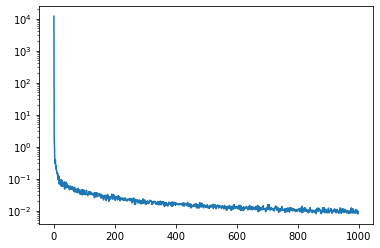

In [6]:
plt.semilogy(losses)  

tensor(0.0084, device='cuda:0', grad_fn=<AddBackward0>)


/home/emastr/anaconda3/envs/pimlenv/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([1, 242])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


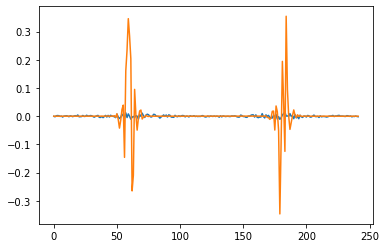

In [7]:
net.to("cuda")
plt.plot(net(xflat[0,:]).cpu().detach().numpy())
plt.plot(yflat[0,:].cpu().detach().numpy())
print(loss(net(xflat[0,:]), yflat[0,:]))

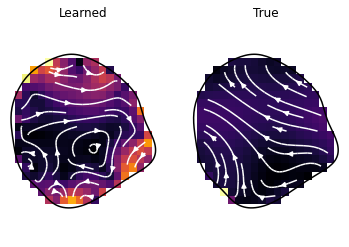

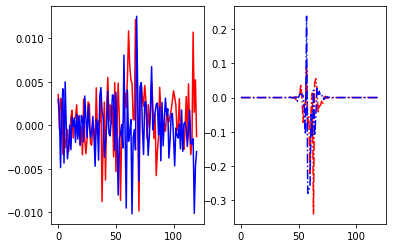

In [8]:
data = ProblemData.random_problemdata(K=K_in, 
                                      bound_amplitude=0.1,
                                      bound_decay=0.5, 
                                      cond_amplitude=0.5,
                                      cond_decay=0.4,
                                      allow_intersections=False, 
                                      allow_net_flow=False,
                                      decay_type="exp",
                                      refine=4,
                                      tol=1e-13)


net.to("cpu")
data.density_coef = net.evaluate(data.bound_coef, data.u_coef)
problem = data.to_problem(n=4)
learned = data.density_coef
#print(xflat.shape)
#print(net(xflat[0:1,:].to("cpu")))

plt.subplot(1,2,1)
plt.title("Learned")
field = lambda z: np.abs(problem.evaluate(z))
problem.geometry.plot(ax = plt.gca(), color="black")
problem.geometry.plot_field(ax=plt.gca(), func=field, npts=20, apply_mask=True, cmap="inferno")#, vmin=0, vmax=1)
problem.geometry.plot_stream(ax=plt.gca(), func=problem.evaluate, npts=20, apply_mask=True, color="white", density=0.5)
plt.axis("equal")
remove_axes(plt.gca())

plt.subplot(1,2,2)
plt.title("True")
problem.solve()
problem.geometry.plot(ax = plt.gca(), color="black")
problem.geometry.plot_field(ax=plt.gca(), func=field, npts=20, apply_mask=True, cmap="inferno")#, vmin=0, vmax=1)
problem.geometry.plot_stream(ax=plt.gca(), func=problem.evaluate, npts=20, apply_mask=True, color="white", density=0.5)
plt.axis("equal")
remove_axes(plt.gca())

plt.figure()
plt.subplot(1,2,1)
data.set_density(n=4, K_density=K_out)
plt.plot(np.real(learned), 'r-')
plt.plot(np.imag(learned), 'b-')

plt.subplot(1,2,2)
plt.plot(np.real(data.density_coef), 'r-.')
plt.plot(np.imag(data.density_coef), 'b-.')


## Convolutional networks
Save the data as (N, C, M) where N is number of data points, C is number of channels and M is the number of discrete points.

In [2]:
data = torch.load("data/problem_data.torch")
d_i = data["X"] # Remove later
d_o = data["Y"]

N = d_i.shape[0]
M = 128
t = np.linspace(0,2*np.pi,M+1)[:-1]

X = np.zeros((N, 4, M)) # 4 = real(bound), imag(bound), real(u0), imag(u0)
Y = np.zeros((N, 2, M)) # 2 = real(dens), imag(dens)

for i in range(N):
    blobData = ProblemData(bound_coef = (d_i[i, 0, :] + 1j * d_i[i, 1, :]).numpy(), 
                       u_coef = (d_i[i, 2, :] + 1j * d_i[i, 3, :]).numpy(), 
                       density_coef=(d_o[i, 0, :] + 1j * d_o[i, 1, :]).numpy())
    bound = blobData.get_bound()
    u0 = blobData.get_u()
    dens = blobData.get_density()
    
    
    z = bound(t)
    w = u0(t)*1j
    c = dens(t)
    
    X[i,0,:],X[i,1,:] = np.real(z), np.imag(z)
    X[i,2,:],X[i,3,:] = np.real(w), np.imag(w)
    Y[i,0,:],Y[i,1,:] = np.real(c), np.imag(c)
    
    #plt.plot(X[i,0,:], X[i,1,:], 'k')
    #plt.quiver(X[i,0,:], X[i,1,:], X[i,2,:], X[i,3,:], color='blue')
    #plt.quiver(X[i,0,:], X[i,1,:], Y[i,0,:],Y[i,1,:], color='red')
X = torch.from_numpy(X)
Y = torch.from_numpy(Y)

data = {"X":X, "Y":Y, "info": \
        "X is (N,C,M) with N datapoints, C=4 channels,\
        and M discretisation pts. C=(real(z), imag(z), real(u0),imag(u0))."}

torch.save(data, "data/discretised_data.torch")

In [3]:
data = torch.load("data/discretised_data.torch")
#data = torch.load("data/discretised_data_gradflow_big.torch")
#data = torch.load("data/discretised_data_gradflow_big_circles.torch")

X = data["X"]
Y = data["Y"]

titles=["boundary x", "boundary y", "inlet x", "inlet y"]
plt.figure(figsize=(7,9))
for i in range(2):
    for j in range(2):
        plt.subplot(1,6,i+3*j+1)
        plt.imshow(X[:,2*i+j,:].squeeze().numpy())
        plt.title(titles[2*i+j])
        remove_axes(plt.gca())
        
ytitles = ["density x", "density y"]
for i in range(2):
    plt.subplot(1,6,3+3*i)
    plt.imshow(Y[:,i,:].squeeze().numpy())
    plt.title(ytitles[i])
    remove_axes(plt.gca())
    
plt.figure()
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.plot(X[i,0,:],X[i,1,:])
    remove_axes(plt.gca())
    
plt.figure()
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.plot(X[i,2,:],'b-')
    plt.plot(X[i,3,:],'r-')
    plt.plot(Y[i,0,:],'r--')
    plt.plot(Y[i,1,:],'b--')
    remove_axes(plt.gca())

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
from util.unet import *

settings = {"in_channels":4, 
            "min_out_channels":4,
            "out_channels":2,
            "depth":4, 
            "batch_norm":2, 
            "width":2,
            "kernel_size":3,
            "padding":1,
            "activation":nn.Sigmoid
           }
#activations = {"sigmoid": nn.Sigmoid, "relu": nn.ReLU}
#settings["activation"] = activations[settings["activation"]]

unet = Unet(**settings)


loss = nn.MSELoss()
#loss = nn.SmoothL1Loss(beta=0.1)

#optim = torch.optim.SGD(unet.parameters(), lr=1e-3)
optim = torch.optim.Adam(unet.parameters(), weight_decay=0.1)#0.00001 # Use default parameters

n = int(0.7*X.shape[0]) # Train on 70%
Xtrain, Ytrain = X[:n,:,:], Y[:n,:,:]
Xtest, Ytest = X[n:,:,:], Y[n:,:,:]

losses_train = []
losses_test = []

nsteps = 4000#200000 # 100000 produces actually good results
for i in range(nsteps):
    
    optim.zero_grad()
    loss_train = loss(unet(Xtrain), Ytrain)
    loss_train.backward()
    optim.step()
    
    losses_train.append(loss_train.item()**2)
    
    
    unet.eval()
    with torch.no_grad():
        losses_test.append(loss(unet(Xtest), Ytest).item())
    unet.train()
    
    print(f"{i}/{nsteps} done. Training loss: {losses_train[-1]}, Test loss: {losses_test[-1]} on {Xtrain.shape[0]} points", end="\r")
    

torch.save({"settings": settings,
            "state dict": unet.state_dict(), 
            "train loss": losses_train, 
            "test loss": losses_test}, 
           "data/unet_state_dict_2022_04_28_3.Torch") # Kernel size 5, stride 2

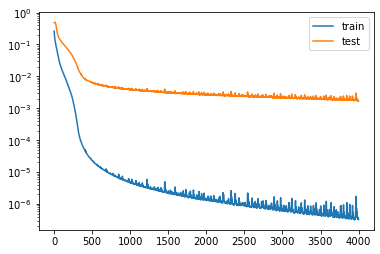

In [26]:
# U-net fast i Fourierdomänen 
# Gör en sammanfattning av allt hittills
# Vad betyder egentligen det vi gör statistikt?
# Skicka runt
save_state = torch.load("data/unet_state_dict_2022_04_28_2.Torch")
net = Unet(**save_state["settings"])
net.eval()

net.load_state_dict(save_state["state dict"])

plt.semilogy(save_state["train loss"], label='train')
plt.semilogy(save_state["test loss"], label='test')
plt.legend()

#torch.save(unet.state_dict(), "data/unet_state_dict_2022_04_01.Torch") # Kernel size 3
#torch.save(loss_data, "data/unet_loss_2022_04_01.Torch") 



(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

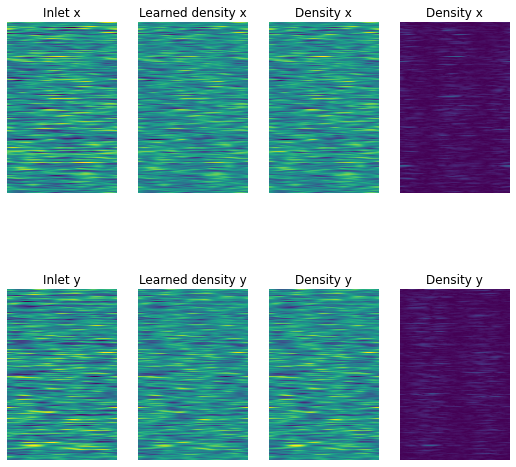

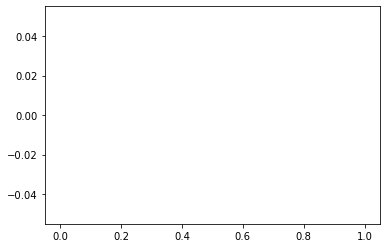

In [27]:
axis=["x","y"]
y = net(X)
plt.figure(figsize=(9,9))
for i in range(2):
    plt.subplot(2,4,4*i+1)
    plt.imshow(X[:,i+2,:].squeeze().detach().numpy(), vmin=-2, vmax=2)
    plt.title(f"Inlet {axis[i]}")
    remove_axes(plt.gca())
    
    plt.subplot(2,4,4*i+2)
    plt.imshow(y[:,i,:].squeeze().detach().numpy(), vmin=-2, vmax=2)
    plt.title(f"Learned density {axis[i]}")
    remove_axes(plt.gca())
    
    plt.subplot(2,4,4*i+3)
    plt.imshow(Y[:,i,:].squeeze().detach().numpy(), vmin=-2, vmax=2)
    plt.title(f"Density {axis[i]}")
    remove_axes(plt.gca())

    plt.subplot(2,4,4*i+4)
    plt.imshow((Y[:,i,:]-y[:,i,:]).abs().squeeze().detach().numpy(), vmin=0, vmax=2)
    plt.title(f"Density {axis[i]}")
    remove_axes(plt.gca())

    
errors = ((Y[740:,:,:]-y[740:,:,:])**2).mean(axis=(1,2))
plt.figure()
errs = [l.item() for l in list(errors.detach().cpu().squeeze())]
plt.hist(errs, bins=20)

0.01947301038115263


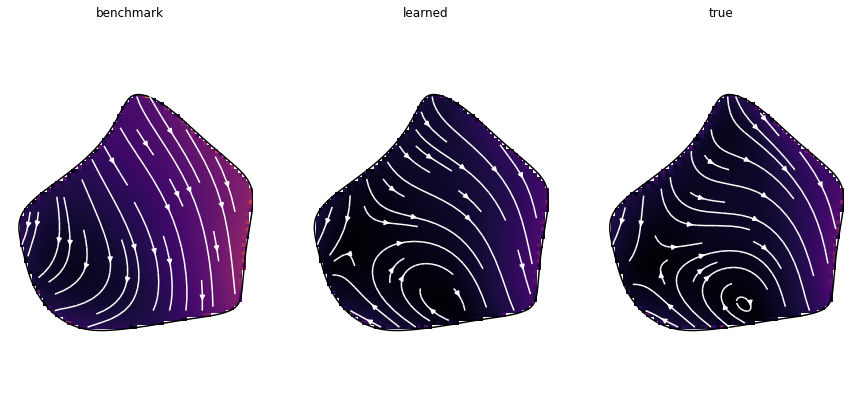

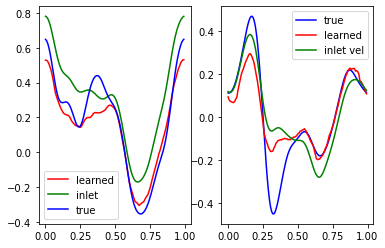

In [28]:
K_in = 20
K_out = 40
M = 128
data = ProblemData.random_problemdata(K=K_in, 
                                      bound_amplitude=0.2,
                                      bound_decay=0.6,#0.5, 
                                      cond_amplitude=0.2,#.5
                                      cond_decay=0.6,#.4
                                      allow_intersections=False, 
                                      allow_net_flow=False,
                                      decay_type="exp",
                                      refine=4,
                                      tol=1e-13)

problem = data.to_problem(n=0)
problem.geometry.grid.ABSCISSA = np.linspace(-1,1,M+1)[:-1]
problem.geometry.grid.WEIGHTS = np.ones((M,)) * 2/M


t = np.linspace(0,2*np.pi,M+1)[:-1]
z = problem.geometry.eval_param(t=t)
w = problem.condition(t)

x = np.zeros((1,4,M))
x[0,0,:],x[0,1,:] = np.real(z), np.imag(z)
x[0,2,:], x[0,3,:] = -np.imag(w), np.real(w)

x = torch.from_numpy(x)
d = net(x)
learned = (d[0,0,:] + 1j*d[0,1,:]).detach().numpy()
benchmark = 1j*w
problem.solve()

densities = [benchmark, learned, problem.density]
titles = ["benchmark", "learned", "true"]

field = lambda z: np.abs(problem.evaluate(z))

plt.figure(figsize=(15,7))
for i in range(3):
    problem.density = densities[i]
    plt.subplot(1,3,i+1)
    plt.title(titles[i])
    problem.geometry.plot(ax = plt.gca(), color="black")
    problem.geometry.plot_field(ax=plt.gca(), func=field, npts=60, apply_mask=True, cmap="inferno", vmin=0, vmax=3)
    problem.geometry.plot_stream(ax=plt.gca(), func=problem.evaluate, npts=60, apply_mask=True, color="white", density=0.5)
    plt.axis("equal")
    remove_axes(plt.gca())

plt.figure()

angle = t/2/np.pi
plt.subplot(121)
plt.plot(angle, np.real(learned),'r-', label="learned")
plt.plot(angle, np.real(1j*w), 'g-', label="inlet")
plt.plot(angle, np.real(problem.density), 'b-', label="true")
plt.legend()

plt.subplot(122)
plt.plot(angle, np.imag(problem.density), 'b-', label="true")
plt.plot(angle, np.imag(learned), 'r-', label="learned")
plt.plot(angle, np.imag(1j*w), 'g-', label="inlet vel")
plt.legend()


print(np.mean(np.abs(learned - problem.density)**2))